In [1]:
import pandas
import pm4py
from pm4py.objects.log.obj import EventLog, Trace
from nltk.cluster import KMeansClusterer
import nltk 
from sklearn import cluster
from sklearn import metrics
import time
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [2]:
event_log = pandas.read_csv('logs/TJSP-BL-event-log.csv', sep=',')
event_log = pm4py.format_dataframe(event_log, case_id='lawsuit_id', activity_key='movement', timestamp_key='date')
event_log['date']=pd.to_datetime(event_log['date'], utc=True) # format the timestamp column

In [3]:
event_log.head()

,lawsuit_id,date,movement,order,status,area,subject_matter,control,digital,class,distribution_date,court_department,claim_amount,judge,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,0000536-07.2020.8.26.0003,2020-01-04 00:00:00+00:00,Decisão,0,NaN,Cível,Franquia,2020/000087,VERDADEIRO,Procedimento Comum Cível,2020-04-02 13:06:00+00:00,2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...,"17.284,24",NBJH56504647452616,0000536-07.2020.8.26.0003,Decisão,2020-01-04 00:00:00+00:00,0,0
1,0000536-07.2020.8.26.0003,2020-01-06 00:00:00+00:00,Conclusos para Decisão,2,NaN,Cível,Franquia,2020/000087,VERDADEIRO,Procedimento Comum Cível,2020-04-02 13:06:00+00:00,2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...,"17.284,24",NBJH56504647452616,0000536-07.2020.8.26.0003,Conclusos para Decisão,2020-01-06 00:00:00+00:00,1,0
2,0000536-07.2020.8.26.0003,2020-01-06 00:00:00+00:00,Conclusos para Despacho,1,NaN,Cível,Franquia,2020/000087,VERDADEIRO,Procedimento Comum Cível,2020-04-02 13:06:00+00:00,2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...,"17.284,24",NBJH56504647452616,0000536-07.2020.8.26.0003,Conclusos para Despacho,2020-01-06 00:00:00+00:00,2,0
3,0000536-07.2020.8.26.0003,2020-01-06 00:00:00+00:00,Certidão de Cartório Expedida,0,NaN,Cível,Franquia,2020/000087,VERDADEIRO,Procedimento Comum Cível,2020-04-02 13:06:00+00:00,2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...,"17.284,24",NBJH56504647452616,0000536-07.2020.8.26.0003,Certidão de Cartório Expedida,2020-01-06 00:00:00+00:00,3,0
4,0000536-07.2020.8.26.0003,2020-01-22 00:00:00+00:00,Decisão,2,NaN,Cível,Franquia,2020/000087,VERDADEIRO,Procedimento Comum Cível,2020-04-02 13:06:00+00:00,2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...,"17.284,24",NBJH56504647452616,0000536-07.2020.8.26.0003,Decisão,2020-01-22 00:00:00+00:00,4,0


In [4]:
def retrieve_traces(log):
    traces, ids = [], []
    for id in log["case:concept:name"].unique():
        events = list(log[log["case:concept:name"] == id]["concept:name"])
        traces.append(["".join(x) for x in events])
        ids.append(id)

    return ids, traces

def run_doc2vec_from_ft(vector_size, log):
    ids, traces = retrieve_traces(log)
    start_time = time.time()
    tagged_traces = [TaggedDocument(words=act, tags=[str(i)]) for i, act in enumerate(traces)]
  
    # build the model
    model = Doc2Vec(tagged_traces,dm = 0, alpha=0.025, vector_size=vector_size, window=5, min_alpha=0.001, min_count=2, epochs=10)
    model.build_vocab(tagged_traces)
    model.train(tagged_traces, total_examples=model.corpus_count, epochs=model.epochs)


    #model.save('output/'+folderName+'T2VVS'+str(vectorsize) +'.model')
    #model.save_word2vec_format('output/'+folderName+ 'T2VVS'+str(vectorsize) + '.word2vec')

    vectors = [model.infer_vector(trace) for trace in traces]
    
    end_time = time.time() - start_time
    print(f"\nDoc2vec took {round(end_time, 2)} seconds")

    # saving
    encoded_df = pd.DataFrame(vectors, columns=[f'{i}' for i in range(vector_size)])
    encoded_df.insert(2, "case", ids)
    return encoded_df, traces


def create_cluster_kmeans(event_log, traces, encoding, num_clusters):
    kmeans = cluster.KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(encoding[["0", "1"]])
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    pca = PCA(n_components=2).fit(encoding[["0", "1"]])
    datapoint = pca.transform(encoding[["0", "1"]])
    print(datapoint)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure
    label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#800d00", "#ff2d00", "#ff7100", "#cdff00","#00b9ff", "#ff00f4"]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
    
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='D', s=200, c='#000000')
    plt.show()

    encoding.insert(3, "d0", datapoint[:, 0])
    encoding.insert(4, "d2", datapoint[:, 1])

    silhouette_score = metrics.silhouette_score(encoding[["0", "1"]], labels)

    print ("[KM]Num_clusters: ")
    print (num_clusters)
    print ("[KM]Silhouette_score: ")
    print (silhouette_score)

    already_seen = {}
    cluster_list = []

    #for i in range(len(traces)):
    #    if not labels[i] in already_seen:
    #        already_seen[labels[i]] = len(list(already_seen.keys()))
    #        cluster_list.append([])
    #    trace = traces[i]
    #    cluster_list[already_seen[labels[i]]].append(trace)
    encoding.insert(5, "traces", traces)
    return encoding, centroidpoint
    



Doc2vec took 4.07 seconds
Traces:
4795
[[ 0.02605948  0.09371299]
 [-0.45022202 -0.01429331]
 [-0.7435342  -0.15912116]
 ...
 [-0.48612878 -0.0227797 ]
 [-1.0126276  -0.2011823 ]
 [ 0.5913757  -0.08419317]]


/Users/cadu/Documents/desenvolvimento/workspace/ml/my_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


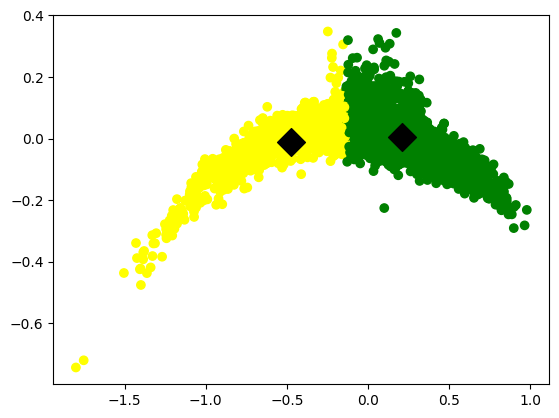

[KM]Num_clusters: 
2
[KM]Silhouette_score: 
0.5404274


In [23]:
vector_size = 2
num_clusters = 2
encoding1, traces = run_doc2vec_from_ft(vector_size, event_log)
print("Traces:")
print(len(traces))
encoding1, centroidpoint = create_cluster_kmeans(event_log, traces, encoding1, num_clusters)

In [24]:
encoding1

,0,1,case,d0,d2,traces
0,-0.662889,0.168353,0000536-07.2020.8.26.0003,0.026059,0.093713,"[Decisão, Conclusos para Decisão, Conclusos pa..."
1,-0.857043,-0.279770,0001566-51.2018.8.26.0002,-0.450222,-0.014293,"[Remetido ao DJE, AR Positivo Juntado, Conclus..."
2,-1.053575,-0.541269,0001981-56.2010.8.26.0053,-0.743534,-0.159121,"[Remetido ao DJE, Distribuído Livremente (por ..."
3,-0.727184,0.417982,0002947-33.2019.8.26.0011,0.259510,-0.015602,[Remetidos os Autos para o Cartório Distribuid...
4,-0.648469,0.101963,0003961-42.2020.8.26.0100,-0.036522,0.120152,"[Conclusos para Sentença, Conclusos para Despa..."
...,...,...,...,...,...,...
4790,-0.693354,0.356283,1134499-65.2018.8.26.0100,0.205124,0.029047,[Distribuído Livremente (por Sorteio) (movimen...
4791,-0.873664,-0.321170,1134501-35.2018.8.26.0100,-0.493981,-0.022978,[Distribuído Livremente (por Sorteio) (movimen...
4792,-0.872018,-0.313490,1134504-87.2018.8.26.0100,-0.486129,-0.022780,[Distribuído por Direcionamento (movimentação ...
4793,-1.144636,-0.797957,1134513-49.2018.8.26.0100,-1.012628,-0.201182,[Distribuído Livremente (por Sorteio) (movimen...


In [25]:
centroidpoint

array([[-0.47732073, -0.01024586],
       [ 0.21164763,  0.00454319]], dtype=float32)

In [26]:
from scipy.cluster.vq import vq
closest, distances = vq(centroidpoint, encoding1[["d0", "d2"]])


In [27]:
closest

array([ 787, 3135], dtype=int32)

In [29]:
print(encoding1.iloc[787:788])
print(encoding1.iloc[3135:3136])

            0         1                       case        d0        d2  \
787 -0.859621 -0.311695  1008745-55.2019.8.26.0011 -0.482074 -0.010927   

                                                traces  
787  [Petição Juntada, AR Positivo Juntado, AR Nega...  
             0         1                       case       d0        d2  \
3135 -0.715539  0.369607  1066466-23.2018.8.26.0100  0.21412  0.004782   

                                                 traces  
3135  [Ausência de pressupostos processuais, Conclus...  
